In [38]:
! pip install geopandas
! pip install pandas
! pip install pygeos
! pip install boto
! pip install s3fs
! pip install shapely
! pip install gcsfs
!pip install contextily
!pip install matplotlib-scalebar
!pip install sklearn
!pip install zipfile
!pip install random
import random
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import time
from itertools import groupby
import geopandas as gpd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


In [2]:
def addGeometryIdToDataFrame(df, gdf, xcol, ycol, idColumn="geometry", df_geom='epsg:4326'): 
    gdf.crs = {'init': 'epsg:4326'}
    gdf_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[xcol], df[ycol]))
    gdf_data.crs = {'init': df_geom}
    joined = gpd.sjoin(gdf_data.to_crs('epsg:26910'), gdf.to_crs('epsg:26910'))
    gdf_data = gdf_data.merge(joined['zip'], left_index=True, right_index=True, how="left")
    gdf_data.rename(columns={'zip': idColumn}, inplace=True)
    df = pd.DataFrame(gdf_data.drop(columns='geometry'))
    # df.drop(columns=[xcol, ycol], inplace=True)
    
    return df.loc[~df.index.duplicated(keep='first'), :]

In [3]:
def plot_map(scenario_name, dpi, df, title, title_, vmax, vmin, BGs):
    fig, ax = plt.subplots(figsize=(10, 7))

    # dfs = [result_dict_tra, result_dict_work]
    # titles = ["Share_Transit_trips", "Share_Work_trips"]
    # titles_ = ["Transit usage rate among zip code residents \n %s"%(scenario_name), "Work activities rate among zip code residents \n %s"%(scenario_name)]

    cmap = "viridis"

    gdf = BGs
    gdf = gdf.to_crs('EPSG:3857')



    # Join the two dataframes on a common attribute
    merged = gdf.merge(df, on="zip")

    # Plot the merged data using the values from the pandas DataFrame
    merged.plot(column=title, cmap=cmap, ax=ax, alpha=0.9, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # Add a legend
    # vmin, vmax = merged[title].min(), merged[title].max()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, alpha=0.8, attribution_size=4)
    ax.text(0.05, 0.9, "N\n↑", ha="center", va="center", transform=ax.transAxes, fontsize=14)

    scalebar = ScaleBar(3, "m", length_fraction=0.2, height_fraction=0.02, frameon=False, location='lower right')
    ax.add_artist(scalebar)

    # Create a colorbar axis
    cax = fig.add_axes([0.12 + 1*0.275, 0.07, 0.235, 0.02])

    # Add a colorbar to the plot using the color map and normalization instance
    cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cb.ax.tick_params(labelsize=8)
    tick_fmt = ticker.FormatStrFormatter('%.2f')
    cb.ax.xaxis.set_major_formatter(tick_fmt)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title_)

    plt.savefig("outputs/%s.png"%(scenario_name), dpi=dpi)
    
    return True

In [251]:

def process(Persons, Households, Plans, min_number,
            is_GTFS, is_tra, is_work, is_GTFS_TR
            # Linkstats, Events
           ):
    
    person_to_hs = dict(zip(Persons.index, Persons.household_id))
    person_to_home_x = dict(zip(Persons.index, Persons.home_x))
    person_to_home_y = dict(zip(Persons.index, Persons.home_y))
    
    plans = Plans[Plans['planSelected']==True]
    plans = plans.sort_values(by=['personId','planElementIndex'], ascending=True)
    plans['activityLocationX'] = plans['personId'].map(person_to_home_x)
    plans['activityLocationY'] = plans['personId'].map(person_to_home_y)

    #GTFS
    if is_GTFS:
        GTFS_folders = ['SF','AC','VT','AY','CC','CE','CM','DE','EM','FF','MA','PE'
                           ,'RV','SB','SC','SL','SM','SO','SR','ST','TD','UC','VC','VT','WC', 'WH','BA','Caltrain','AM','HF','GG'
                           ]
        all_stops_sca = pd.DataFrame()
        all_stoptimes_sca = pd.DataFrame()
        for folder in GTFS_folders:
            with zipfile.ZipFile('inputs/GTFS-sfbay/%s.zip'%(folder), 'r') as zip_ref:
                stops = pd.read_csv(zip_ref.open('stops.txt'))
                stop_times = pd.read_csv(zip_ref.open('stop_times.txt'), dtype={'stop_id': str})
                stops['agency'] = folder
                stop_times['agency'] = folder
                stop_to_lat = dict(zip(stops.stop_id.astype(str), stops.stop_lat))
                stop_to_lon = dict(zip(stops.stop_id.astype(str), stops.stop_lon))
                print(folder)
                # print(stop_to_lat)
                stop_times['stop_lat'] = stop_times['stop_id'].astype(str).map(stop_to_lat)
                print(stop_times[:5])
                stop_times['stop_lon'] = stop_times['stop_id'].astype(str).map(stop_to_lon)
                all_stops_sca = pd.concat([all_stops_sca, stops[['stop_id','stop_lat','stop_lon', 'agency']]], ignore_index=True)
                all_stoptimes_sca = pd.concat([all_stoptimes_sca, stop_times[['stop_id','stop_lat','stop_lon', 'agency']]], ignore_index=True)
        
        all_stoptimes =  addGeometryIdToDataFrame(all_stoptimes_sca, BGs, 'stop_lon', 'stop_lat', 'zip')
        all_stoptimes = all_stoptimes.zip.value_counts().to_dict()
        all_stoptimes = pd.DataFrame.from_dict(all_stoptimes, orient='index', columns=['stoptimes'])
        all_stoptimes.index.name = 'zip'
                                           
        all_stops = addGeometryIdToDataFrame(all_stops_sca, BGs, 'stop_lon', 'stop_lat', 'zip')
        all_stops = all_stops.zip.value_counts().to_dict()
        all_stops = pd.DataFrame.from_dict(all_stops, orient='index', columns=['stops'])
        all_stops.index.name = 'zip'
    else:
        all_stops = []
        all_stops_sca = []
        all_stoptimes = []
        all_stoptimes_sca = []
                                           
    
    
    
    #GTFS-TR
    if is_GTFS:
        GTFS_folders = ['SF-TR','AC-TR','BA-TR','Caltrain-TR'
                           ]
        all_stops_sca_TR = pd.DataFrame()
        for folder in GTFS_folders:
            with zipfile.ZipFile('inputs/GTFS-sfbay/%s.zip'%(folder), 'r') as zip_ref:
                stops = pd.read_csv(zip_ref.open('stops.txt'))
                stops['agency'] = folder
                all_stops_sca_TR = pd.concat([all_stops_sca_TR, stops[['stop_id','stop_lat','stop_lon', 'agency']]], ignore_index=True)
        all_stops_TR = addGeometryIdToDataFrame(all_stops_sca_TR, BGs, 'stop_lon', 'stop_lat', 'zip')
        all_stops_TR = all_stops_TR.zip.value_counts().to_dict()
        all_stops_TR = pd.DataFrame.from_dict(all_stops_TR, orient='index', columns=['stops'])
        all_stops_TR.index.name = 'zip'
    else:
        all_stops_TR = []
        all_stops_sca_TR = []
    
    #Transit Usage
    if is_tra:

        plans_trip = plans[plans['legMode'].notnull()]
        plans_transit = plans[(plans['legMode']=='walk_transit')|(plans['legMode']=='drive_transit')|(plans['legMode']=='ride_hail_transit')|(plans['legMode']=='bike_transit')]
        plans_transit = addGeometryIdToDataFrame(plans_transit, BGs, 'activityLocationX', 'activityLocationY', 'zip')
        plans_trip = addGeometryIdToDataFrame(plans_trip, BGs, 'activityLocationX', 'activityLocationY', 'zip')
        plans_transit_dict = plans_transit.zip.value_counts().to_dict()
        plans_trip = plans_trip.zip.value_counts().to_dict()
        result_dict_tra = {key: plans_transit_dict[key]/plans_trip[key] for key in plans_transit_dict if key in plans_trip if plans_trip[key]>min_number}
        df2 = pd.DataFrame.from_dict(result_dict_tra, orient='index', columns=['Share_Transit_trips'])
        df2.index.name = 'zip'
    else:
        df2 = []
        
    #Work Activities
    if is_work:



        plans_act = plans[(plans['activityType'].notnull())&(plans['activityType']!='Home')]
        plans_work = plans[plans['activityType']=='Work']
        plans_work = addGeometryIdToDataFrame(plans_work, BGs, 'activityLocationX', 'activityLocationY', 'zip')
        plans_act = addGeometryIdToDataFrame(plans_act, BGs, 'activityLocationX', 'activityLocationY', 'zip')
        plans_work_dict = plans_work.zip.value_counts().to_dict()
        plans_act = plans_act.zip.value_counts().to_dict()
        result_dict_work = {key: plans_work_dict[key]/plans_act[key] for key in plans_work_dict if key in plans_act  if plans_trip[key]>min_number}
        df1 = pd.DataFrame.from_dict(result_dict_work, orient='index', columns=['Share_Work_trips'])
        df1.index.name = 'zip'
    else:
        df1 = []


    
    
    return df1, df2, all_stops, all_stops_sca, all_stops_TR, all_stops_sca_TR, all_stoptimes, all_stoptimes_sca


In [208]:
#Read
BGs = gpd.read_file('inputs/geo_export_9539336a-a70d-42a4-93a6-0df79b218c82.shp')

Dir_sce = 'sfbay-baseline-20230503-omx'
Dir_sce_TR = 'sfbay-TR-20230505'
year = '2020'
ite = '4'

Dir_beam = 'gs://beam-core-outputs/'+Dir_sce+'/beam/year-'+year+'-iteration-'+ite+'/ITERS/it.0'
Dir_act = 'gs://beam-core-outputs/'+Dir_sce+'/activitysim/year-'+year+'-iteration-'+ite
Dir_beam_TR = 'gs://beam-core-outputs/'+Dir_sce_TR+'/beam/year-'+year+'-iteration-'+ite+'/ITERS/it.0'
Dir_act_TR = 'gs://beam-core-outputs/'+Dir_sce_TR+'/activitysim/year-'+year+'-iteration-'+ite

#Simulated person and Households
Persons = pd.read_csv(Dir_act+'/persons.csv.gz', nrows = None)
Households = pd.read_csv(Dir_act+'/households.csv.gz', nrows = None)
#Planned plans
Plans = pd.read_csv(Dir_beam+'/0.plans.csv.gz', nrows = None)
#Link related outputs
# Linkstats = pd.read_csv(Dir_beam+'/0.linkstats.csv.gz', nrows = 15000000)
#Event file
# Events = pd.read_csv(Dir_beam+'/0.events.csv.gz', nrows = 500000)
#Person to Path Traversal file

# Persons = pd.read_csv(Dir_act_TR+'/persons.csv.gz')
# Households = pd.read_csv(Dir_act_TR+'/households.csv.gz')
# Plans = pd.read_csv(Dir_beam_TR+'/plans.csv.gz')


KeyboardInterrupt



In [252]:
df1_base, df2_base, all_stops, all_stops_sca, all_stops_TR, all_stops_sca_TR, all_stoptimes, all_stoptimes_sca  = process(Persons, Households, Plans, 100,
                             is_GTFS = 1, is_tra = 0, is_work = 0, is_GTFS_TR =1
                             # , Linkstats, Events
                            )

SF
   trip_id arrival_time departure_time stop_id  stop_sequence stop_headsign  \
0  7580387     16:00:00       16:00:00    3892             30                 
1  7580387     16:01:13       16:01:13    3875             31                 
2  7580387     16:02:31       16:02:31    3896             32                 
3  7580387     16:03:16       16:03:16    3879             33                 
4  7580387     16:03:54       16:03:54    3852             34                 

  pickup_type drop_off_type shape_dist_traveled agency   stop_lat  
0                                                   SF  37.787265  
1                                                   SF  37.786923  
2                                                   SF  37.786503  
3                                                   SF  37.786248  
4                                                   SF  37.786042  
AC
   trip_id arrival_time departure_time  stop_id  stop_sequence  pickup_type  \
0  5596203     07:30:00       07

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

In [253]:
def plot_scatter(scenario_name, dpi, df, title, title_lat, title_lon, title_, BGs, msize = 7, legend_cls = 2, is_zoom = 0, legend_loc = 'upper right'):

    # fig, ax = plt.subplots(figsize=(8, 6))
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[title_lon], df[title_lat]), crs='EPSG:4326')
    
    gdf = gdf.dropna(subset=[title])

    
    # Define colors for each agency
    unique_agencies = gdf['agency'].unique()
    num_colors = len(unique_agencies)
    colors = np.array( [(241, 90, 90), (241, 162, 90), (241, 222, 90), (162, 241, 90), (90, 241, 103),           (90, 241, 198), (90, 180, 241), (90, 103, 241), (160, 90, 241), (218, 90, 241),           (241, 90, 196), (225, 23, 79), (255, 87, 34), (255, 195, 0), (123, 200, 0),           (0, 150, 136), (0, 188, 212), (3, 169, 244), (63, 81, 181), (156, 39, 176),          (213, 0, 0), (255, 111, 0), (255, 235, 0), (27, 94, 32), (0, 77, 64),          (0, 96, 100), (0, 145, 234), (57, 73, 171), (94, 53, 177), (226, 0, 116), (255, 158, 0)])/255


    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 12))
    for i, agency in enumerate(unique_agencies):
        x = gdf[gdf['agency']==agency][title_lon]
        y = gdf[gdf['agency']==agency][title_lat]
        ax.scatter(x, y, color=colors[i], label=agency, alpha=1, s=msize,   marker='.')

    ax.legend(loc=legend_loc, fontsize=10, framealpha=1, title='Transit Agencies', markerscale = 2.5, ncol = legend_cls )
    
    
    
    
    # Plot the GeoDataFrame using the random colors
    # ax = gdf.plot(column=title, markersize=0.02, legend=True, figsize=(18, 10), legend_kwds={'title': 'Transit Agency', 'fontsize': 12})
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7, attribution_size=4, crs='EPSG:4326')
    
    
    
    ax.text(0.05, 0.9, "N\n↑", ha="center", va="center", transform=ax.transAxes, fontsize=14)

    scalebar = ScaleBar(100000, "m", length_fraction=0.2, height_fraction=0.02, frameon=False, location='lower right')
    ax.add_artist(scalebar)
    
    # tick_fmt = ticker.FormatStrFormatter('%.2f')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title_)
    
    # Create the zoomed-in plot
    if is_zoom:
        ax2 = ax.inset_axes([0.0, -0.18, 0.5, 0.7])
        for i, agency in enumerate(unique_agencies):
            x = gdf[gdf['agency']==agency][title_lon]
            y = gdf[gdf['agency']==agency][title_lat]
            ax2.scatter(x, y, color=colors[i], label=agency, alpha=1, s=msize/7,   marker='.')
        ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, alpha=0.7, attribution_size=4, crs='EPSG:4326')

        # tick_fmt = ticker.FormatStrFormatter('%.2f')
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        # zoom_xlim = (-100000, 1000000)
        # zoom_ylim = (-100000, 1000000)
        # ax2.set_xlim(zoom_xlim)
        # ax2.set_ylim(zoom_ylim)
        min_latitude = gdf[title_lat].min()
        max_latitude = gdf[title_lat].max()
        min_longitude = gdf[title_lon].min()
        max_longitude = gdf[title_lon].max()


        ax2.set_xlim(min_longitude-(max_longitude-min_longitude)*0.05, max_longitude-(max_longitude-min_longitude)*0.6)
        ax2.set_ylim(min_latitude+(max_latitude-min_latitude)*0.6, max_latitude-(max_latitude-min_latitude)*0.1)

    # plt.savefig("outputs/%s.png"%(scenario_name), dpi=dpi)
    
    return True

True

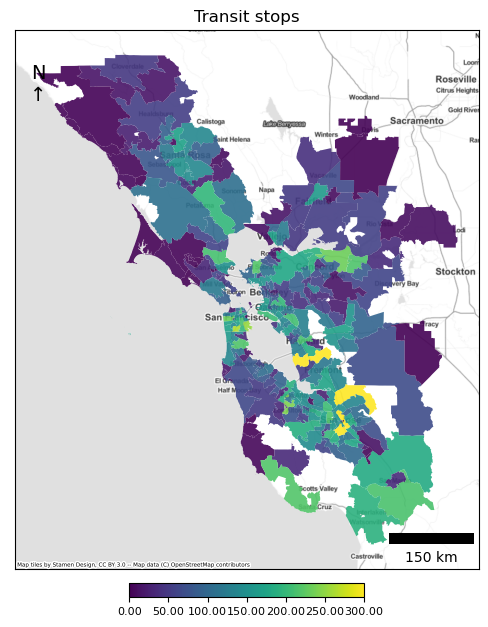

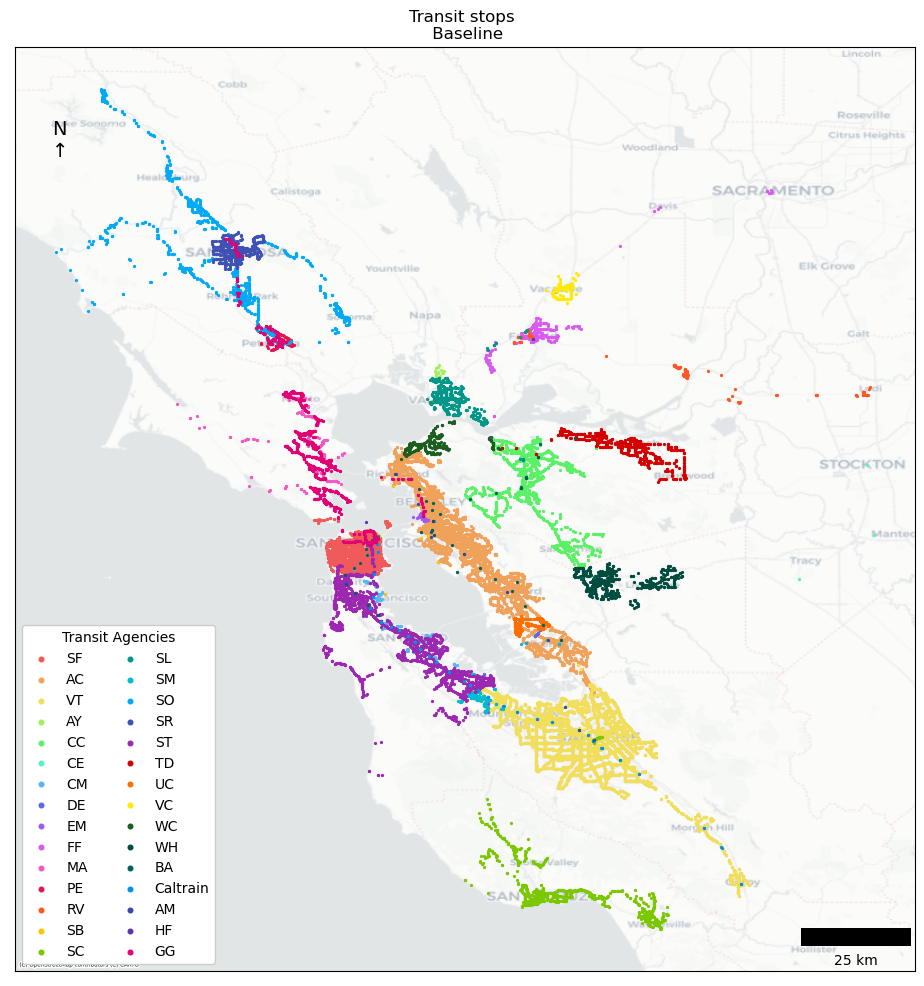

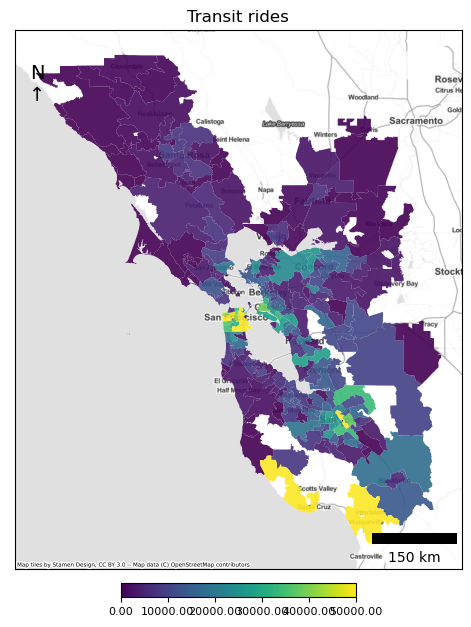

In [254]:
plot_map('Baseline', 100, all_stops,'stops','Transit stops', 300, 0, BGs)
plot_scatter('Baseline', 300, all_stops_sca,'agency','stop_lat','stop_lon','Transit stops \n Baseline', BGs, msize = 7, legend_cls = 2, is_zoom = 0, legend_loc = 'lower left')
# plot_scatter('Baseline', 300, all_stops_sca_TR,'agency','stop_lat','stop_lon','Transit stops \n Baseline', BGs, msize = 100, legend_cls = 1, is_zoom = 1, legend_loc = 'upper right')
#stoptimes from only a week day
plot_map('Baseline', 100, all_stoptimes,'stoptimes','Transit rides', 50000, 0, BGs)
# plot_scatter('Baseline', 300, all_stoptimes_sca,'agency','stop_lat','stop_lon','Transit stops \n Baseline', BGs, msize = 7, legend_cls = 2, is_zoom = 0, legend_loc = 'lower left')


In [226]:
all_stoptimes_sca

,stop_id,stop_lat,stop_lon,agency,geometry
0,40113,NaN,NaN,GG,POINT EMPTY
1,40188,NaN,NaN,GG,POINT EMPTY
2,40170,NaN,NaN,GG,POINT EMPTY
3,40296,NaN,NaN,GG,POINT EMPTY
4,40268,NaN,NaN,GG,POINT EMPTY
...,...,...,...,...,...
71019,40326,NaN,NaN,GG,POINT EMPTY
71020,44002,NaN,NaN,GG,POINT EMPTY
71021,40326,NaN,NaN,GG,POINT EMPTY
71022,44002,NaN,NaN,GG,POINT EMPTY


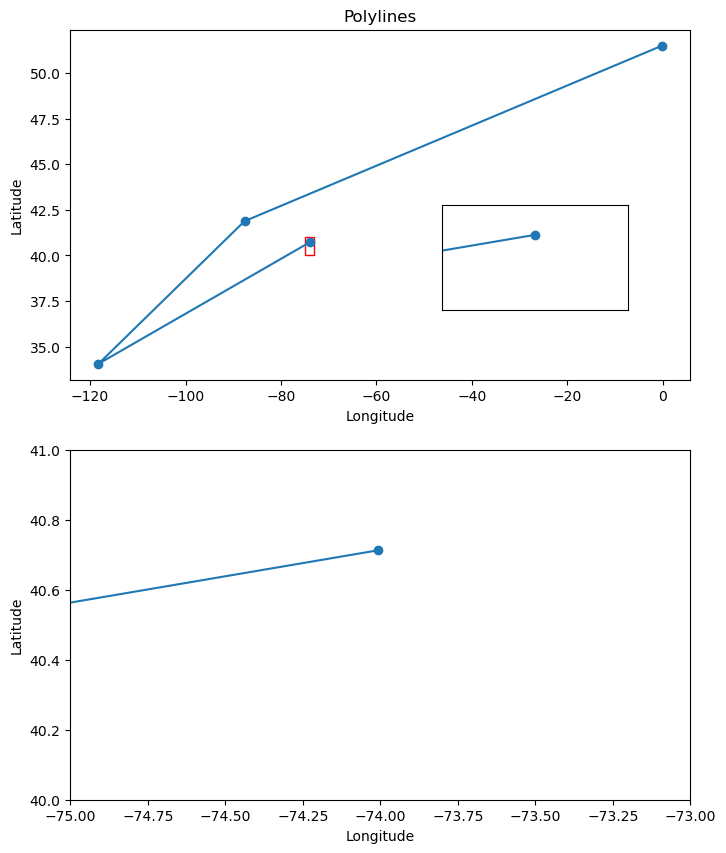

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Example coordinates (latitude and longitude)
coordinates = [
    (40.7128, -74.0060),  # New York City
    (34.0522, -118.2437),  # Los Angeles
    (41.8781, -87.6298),  # Chicago
    (51.5074, -0.1278)  # London
]

# Create a DataFrame from the coordinates
df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

# Create subplots with a main plot and zoomed-in subplot
fig, (ax_main, ax_zoom) = plt.subplots(2, 1, figsize=(8, 10))

# Plot the main polyline
ax_main.plot(df['Longitude'], df['Latitude'], marker='o')
ax_main.set_title('Polylines')

# Specify the region to zoom in
zoom_xlim = (-75, -73)
zoom_ylim = (40, 41)

# Plot the zoomed-in polyline
ax_zoom.plot(df['Longitude'], df['Latitude'], marker='o')
ax_zoom.set_xlim(zoom_xlim)
ax_zoom.set_ylim(zoom_ylim)

# Set the titles and labels
ax_main.set_xlabel('Longitude')
ax_main.set_ylabel('Latitude')
ax_zoom.set_xlabel('Longitude')
ax_zoom.set_ylabel('Latitude')

# Create an inset axis for the zoomed-in plot
ax_inset = ax_main.inset_axes([0.6, 0.2, 0.3, 0.3])
ax_inset.plot(df['Longitude'], df['Latitude'], marker='o')
ax_inset.set_xlim(zoom_xlim)
ax_inset.set_ylim(zoom_ylim)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

# Draw a rectangle to indicate the zoomed-in region
rect = plt.Rectangle((zoom_xlim[0], zoom_ylim[0]), zoom_xlim[1] - zoom_xlim[0], zoom_ylim[1] - zoom_ylim[0], edgecolor='r', facecolor='none')
ax_main.add_patch(rect)

# Display the plot
plt.show()
